In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import pandas as pd
from Priorizacion_funciones.ocupacion_nodos_sin_exo import *
from Priorizacion_funciones.modelo_forecast_sin_exo import *
from Priorizacion_funciones.series_generadas import *
import warnings
warnings.filterwarnings('ignore')
os.getcwd()

'C:\\Users\\CristhianJohnatanIzq\\OneDrive - SQDM\\Proyecto2\\ENVIO_DARIO\\MODELO_PRIORIZACION_DATA_ORIGEN_ADRIANA'

In [5]:
from matplotlib import pyplot

In [13]:
data_completa.head()

,NODO,CMTS,CABLEMAC,OCUPACION,SENTIDO,ANIO,MES,DIA,FECHA
0,C773D,TULU-TULUA-H-01-CS100G,CATV-MAC 13,0.477440,UP,2021,04,05,2021-04-05
1,TN11,BOGO-COT-H-03-CS100G,CATV-MAC 17,0.616279,DOWN,2021,02,08,2021-02-08
2,VGL,VILL-VILL-H-02-CS100G,CATV-MAC 5,0.672510,DOWN,2021,06,07,2021-06-07
3,44A1,BOGO-POLO-H-14-CS100G,CATV-MAC 16,0.553211,UP,2021,05,10,2021-05-10
4,HLN,BOGO-FONT-H-04-CS100G,CATV-MAC 12,0.186385,UP,2021,01,04,2021-01-04


***Dejar sólo un archivo de ocupación completo: si lo envían completo reemplazar el archivo en la carpeta ocupación, si envian sólo el último mes se debe generar sólo uno.***


In [12]:
#data_completa = pd.read_csv('ocupacion/OCUPACION_COMPLETO.csv', sep=';')
data_completa = pd.read_csv('ocupacion/OCUPACION_COMPLETO_old11082021.csv')
data_completa['MES'] = [f'0{x}' if x <10 else str(x) for x in data_completa['MES']]
data_completa['DIA'] = [f'0{x}' if x <10 else str(x) for x in data_completa['DIA']]
data_completa['FECHA'] = data_completa['ANIO'].astype('str') + '-' + data_completa['MES'] + '-' + data_completa['DIA']
data_completa.rename(columns={'CMTC':'CMTS', 'COD_NODO':'NODO'}, inplace=True)
cols_stream = ['CMTS','CABLEMAC','NODO','OCUPACION','FECHA']
downstream = data_completa.loc[(data_completa['SENTIDO']=='DOWN'),cols_stream].copy()
downstream.rename(columns={'OCUPACION':'DW'}, inplace=True)
upstream = data_completa.loc[(data_completa['SENTIDO']=='UP'), cols_stream].copy()
upstream.rename(columns={'OCUPACION':'UP'}, inplace=True)

## Exploracion de la base

In [14]:
data_completa.head()

,NODO,CMTS,CABLEMAC,OCUPACION,SENTIDO,ANIO,MES,DIA,FECHA
0,C773D,TULU-TULUA-H-01-CS100G,CATV-MAC 13,0.477440,UP,2021,04,05,2021-04-05
1,TN11,BOGO-COT-H-03-CS100G,CATV-MAC 17,0.616279,DOWN,2021,02,08,2021-02-08
2,VGL,VILL-VILL-H-02-CS100G,CATV-MAC 5,0.672510,DOWN,2021,06,07,2021-06-07
3,44A1,BOGO-POLO-H-14-CS100G,CATV-MAC 16,0.553211,UP,2021,05,10,2021-05-10
4,HLN,BOGO-FONT-H-04-CS100G,CATV-MAC 12,0.186385,UP,2021,01,04,2021-01-04


In [15]:
downstream.head()

,CMTS,CABLEMAC,NODO,DW,FECHA
1,BOGO-COT-H-03-CS100G,CATV-MAC 17,TN11,0.616279,2021-02-08
2,VILL-VILL-H-02-CS100G,CATV-MAC 5,VGL,0.672510,2021-06-07
6,BOGO-POLO-H-15-CS100G,CATV-MAC 19,30A013,0.473507,2021-02-01
7,PAST-PASTO-H-01-CS100G,CATV-MAC 37,NVR2D,0.584218,2020-07-13
9,BOGO-FONT-H-02-CS100G,CATV-MAC 13,41D1,0.653036,2020-12-14


In [16]:
downstream.describe()

,DW
count,739802.000000
mean,0.595000
std,0.177502
min,0.000000
25%,0.488771
50%,0.606797
75%,0.714275
max,1.050331


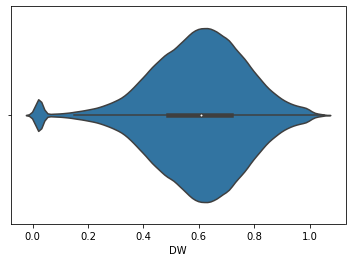

In [17]:
sns.violinplot(x=downstream["DW"]);

In [18]:
upstream.head()

,CMTS,CABLEMAC,NODO,UP,FECHA
0,TULU-TULUA-H-01-CS100G,CATV-MAC 13,C773D,0.477440,2021-04-05
3,BOGO-POLO-H-14-CS100G,CATV-MAC 16,44A1,0.553211,2021-05-10
4,BOGO-FONT-H-04-CS100G,CATV-MAC 12,HLN,0.186385,2021-01-04
5,SOACH-SOACH-H-07-CS100G,CATV-MAC 21,SGT3D,0.474305,2020-06-15
8,BOGO-DATA-H-14-ARRIE6,CABLE-MAC 56,9A4D,0.183117,2021-03-29


In [19]:
upstream.describe()

,UP
count,739040.000000
mean,0.464014
std,0.178690
min,0.000000
25%,0.332468
50%,0.462859
75%,0.590021
max,1.084137


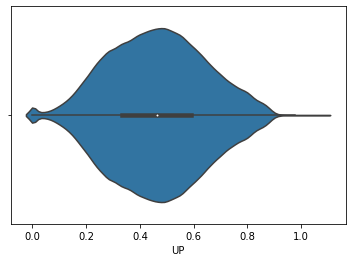

In [20]:
sns.violinplot(x=upstream["UP"]);

## conteo de nodos

In [21]:
downstream.NODO.nunique()

14397

In [22]:
upstream.NODO.nunique()

14355

#### Primer y último registro

In [23]:
estadisticasNodo=data_completa.copy()
estadisticasNodo['periodo']=(estadisticasNodo['ANIO'].astype('int64'))*100+(estadisticasNodo['MES'].astype('int64'))
estadisticasNodo=estadisticasNodo[['NODO','periodo']].groupby('NODO').agg(['min','max'])

In [24]:
#estadisticasNodo.swaplevel(0)
#estadisticasNodo.droplevel('periodo')
estadisticasNodo.columns = estadisticasNodo.columns.droplevel()

In [25]:
estadisticasNodo.head()

,min,max
NODO,,
003,202106,202106
010,202106,202106
011,202106,202106
012,202106,202106
013,202106,202106


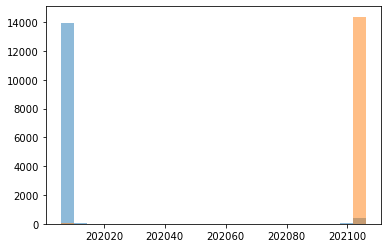

In [26]:
pyplot.hist(estadisticasNodo['min'], 24, alpha=0.5, label='min');
pyplot.hist(estadisticasNodo['max'], 24, alpha=0.5, label='min');

#### Numero Semanas Diferentes

In [27]:
downstream.FECHA.nunique()

55

In [28]:
upstream.FECHA.nunique()

55

#### numero Registros por NODO

In [29]:
InfoByNodo=downstream[['NODO','FECHA']].groupby('NODO').count()
InfoByNodo.describe()

,FECHA
count,14397.000000
mean,51.385844
std,11.674964
min,1.000000
25%,51.000000
50%,54.000000
75%,54.000000
max,630.000000


In [30]:
InfoByNodo.sort_values('FECHA',ascending=False)
#Nodos duplicados por semana, no se toman en cuentas contar cuantos

,FECHA
NODO,
3,630
5,253
2B7011,162
LAB,161
51015M,144
...,...
BP43B,1
300012,1
300014,1


In [31]:
InfoByNodo[InfoByNodo['FECHA']>55].count()

FECHA    444
dtype: int64

In [32]:
InfoByNodo[InfoByNodo['FECHA']<50].count()

FECHA    3379
dtype: int64

In [33]:
InfoByNodoUP=upstream[['NODO','FECHA']].groupby('NODO').count()
InfoByNodoUP.describe()

,FECHA
count,14355.000000
mean,51.483107
std,12.477045
min,1.000000
25%,52.000000
50%,55.000000
75%,55.000000
max,629.000000


In [34]:
InfoByNodoUP[InfoByNodoUP['FECHA']>55].count()

FECHA    1011
dtype: int64

In [35]:
InfoByNodoUP[InfoByNodoUP['FECHA']<50].count()

FECHA    3121
dtype: int64

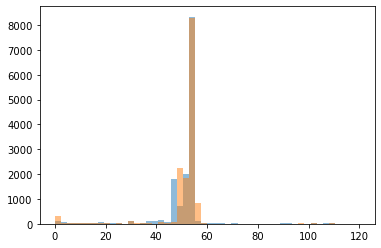

In [36]:
pyplot.hist(InfoByNodo['FECHA'], 50, alpha=0.5, label='dw',range=[0, 120]);
pyplot.hist(InfoByNodoUP['FECHA'], 50, alpha=0.5, label='up',range=[0, 120]);

####  Nodo Validacion

In [37]:
sampleDW=InfoByNodo[InfoByNodo['FECHA']==55].sort_values('FECHA',ascending=False).head(10)

In [38]:
sampleDW

,FECHA
NODO,
09A,55
M4T,55
M2T,55
LVS,55
LVA,55
LUS,55
LUI,55
LU3,55
LU2,55


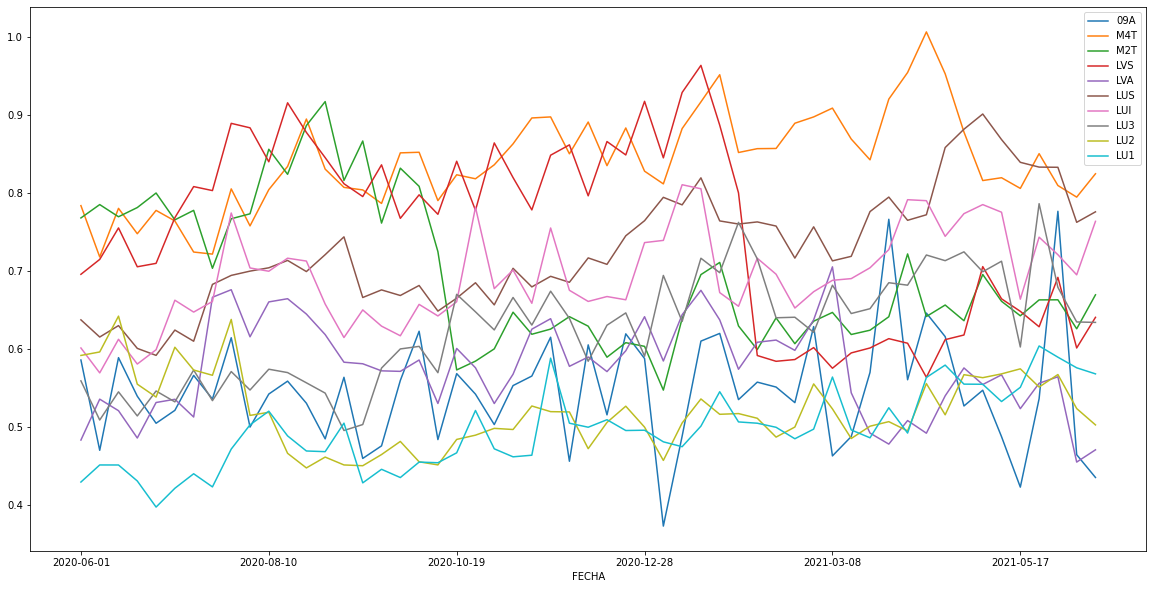

In [39]:
#downstream[downstream['NODO']=='09A'].sort_values('FECHA',ascending=True).plot(x='FECHA',y='DW', kind='line')
#downstream[downstream['NODO'].isin(sampleDW.index)].sort_values('FECHA',ascending=True).plot(x='FECHA',y='DW', kind='line')
fig, ax = plt.subplots(figsize=(20,10))
for ind, row in sampleDW.iterrows():   
    downstream[downstream['NODO']==ind].sort_values('FECHA',ascending=True).plot(x='FECHA',y='DW',ax=ax, kind='line', label=ind)
    

In [40]:
sampleUP=InfoByNodoUP[InfoByNodoUP['FECHA']==55].sort_values('FECHA',ascending=False).head(10)

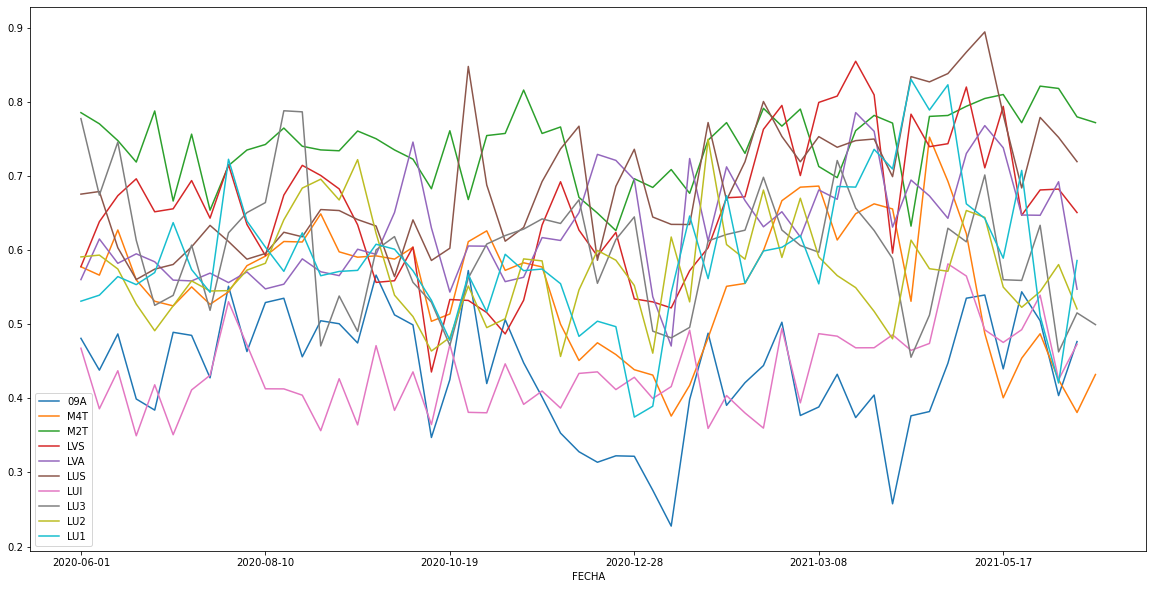

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
for ind, row in sampleDW.iterrows():   
    upstream[upstream['NODO']==ind].sort_values('FECHA',ascending=True).plot(x='FECHA',y='UP',ax=ax, kind='line', label=ind)

### Exacutar Modelo y validar
* programar modelo autoriarima
* validar con los resultados actuales

###  funcion modelo nodos

In [42]:
def run_modelo(df, DW_UP,n_nodos, f_ini, f_fin, load_model):
    df = df.copy()
    df['FECHA'] =pd.to_datetime(df['FECHA'], dayfirst=True)
    nodos = list(df['NODO'].unique())
    if n_nodos ==-1:
        nodo_ex = nodos
    else:
        nodo_ex = nodos[0:n_nodos]
    print(f"{50*'-'}\nTiempo de inicio de la corrida del modelo: {time.strftime('%Y-%m-%d %H:%M')}\n{50*'-'}")
    Parallel(n_jobs=-1, verbose=1)(delayed(run_modelo_nodo)(nodo, df, f_ini, f_fin, DW_UP, load_model) for nodo in nodo_ex)
    time.sleep(5)
    print(f"{50*'-'}\nTiempo de finalización de la corrida del modelo: {time.strftime('%Y-%m-%d %H:%M')}\n{50*'-'}")

In [43]:
def run_modelo_nodo(j , df, fecha_ini_fore, fecha_final_fore, DW_UP, load_model): 
    try:
        week_final = pd.to_datetime(fecha_final_fore, dayfirst=True).week
        week_ini = pd.to_datetime(fecha_ini_fore, dayfirst=True).week
        n_periodos_fore = week_final- week_ini +1        
        filtro_train = f"FECHA >= '2020-06-01' and FECHA <'{fecha_ini_fore}'"
        filtro_test = f"FECHA >= '{fecha_ini_fore}' and FECHA <='{fecha_final_fore}'"        
        nodo = df.loc[df['NODO'] == j] # Dataframe de Nodo Ejemplo
        nodo = nodo.sort_values("FECHA") #Orden por fecha 
        df_comp = nodo.copy()        
        # %% ---- Generando Serie
        df_serie = df_comp[["FECHA", DW_UP]] 
        df_serie.set_index("FECHA", inplace=True) 
        df_serie = df_serie.asfreq("W-MON") # Frecuencia de serie semanal, dia lunes
        df_serie = df_serie.fillna(method = "ffill")        
        # SE GENERA SERIE DE TRAIN Y TEST
        df_serie_train = df_serie.query(filtro_train)
        df_serie_test = df_serie.query(filtro_test)
        df_comp = nodo.copy()
        ruta_modelo = f"MODELOS/MODELOS_ARIMA_TRAFICOS/{DW_UP}_{j}.pkl"
        if load_model:
            model_auto_2 = load(ruta_modelo)            
        else:
            model_auto_2 = auto_arima(df_serie_train,max_p = 4, max_q = 4,trace=False)
            dump(model_auto_2, ruta_modelo)           
        # %% ---- DF Forecast
        ind = pd.date_range(fecha_ini_fore, periods = n_periodos_fore, freq ='W-MON', name='FECHA')        
        df_auto_fore = pd.DataFrame(model_auto_2.predict(n_periods = len(ind)), index = ind)
        df_auto_fore.columns = [DW_UP]
        df_final = df_comp[["FECHA",DW_UP]]
        df_final.set_index("FECHA", inplace=True)
        divi = {'UP':(27*4), 'DW':(38*48)}
        forenodo = pd.concat([df_final,df_auto_fore], axis=0)
        forenodo["NODO"] = j
        forenodo[f"OCUPACION_{DW_UP}"] = forenodo[DW_UP] 
        forenodo[DW_UP] = forenodo[f"OCUPACION_{DW_UP}"]*divi[DW_UP]
        forenodo.to_csv(f"Data_out_modelo/{DW_UP}_{j}.csv", index = True)        
    except:
        pass

###  Depurar funcion

In [44]:
downstream.dtypes

CMTS         object
CABLEMAC     object
NODO         object
DW          float64
FECHA        object
dtype: object

In [45]:
df=downstream
df['FECHA'] =pd.to_datetime(df['FECHA'], dayfirst=True)

In [46]:
#### fechas de lunes (automatizar fechas)
#### se recomienda dejar tres fechas de validación y predecir dos
fecha_ini_fore = '2021-05-31'
fecha_final_fore  = '2021-06-28'
##fecha_final_fore  = '2021-01-03'
# Para correr todos colocar -1
n_nodos = 20

In [47]:
week_final = pd.to_datetime(fecha_final_fore, dayfirst=True).week
week_final

26

In [48]:
week_ini = pd.to_datetime(fecha_ini_fore, dayfirst=True).week
week_ini

22

In [49]:
n_periodos_fore = week_final- week_ini +1
n_periodos_fore

5

In [50]:
filtro_train = f"FECHA >= '2020-06-01' and FECHA <'{fecha_ini_fore}'"
filtro_train

"FECHA >= '2020-06-01' and FECHA <'2021-05-31'"

In [51]:
filtro_test = f"FECHA >= '{fecha_ini_fore}' and FECHA <='{fecha_final_fore}'"
filtro_test

"FECHA >= '2021-05-31' and FECHA <='2021-06-28'"

###  un solo nodo

In [52]:
sampleDW[:2]

,FECHA
NODO,
09A,55
M4T,55


In [53]:
nodo = df.loc[df['NODO'] == '2NZ'] # Dataframe de Nodo Ejemplo
nodo = nodo.sort_values("FECHA") 

In [54]:
nodo.head()

,CMTS,CABLEMAC,NODO,DW,FECHA
92494,CALI-MELE-H-03-CS100G,CATV-MAC 24,2NZ,0.346932,2020-06-01
51,CALI-MELE-H-03-CS100G,CATV-MAC 24,2NZ,0.347309,2020-06-22
386511,CALI-MELE-H-03-CS100G,CATV-MAC 24,2NZ,0.354083,2020-06-29
888570,CALI-MELE-H-03-CS100G,CATV-MAC 24,2NZ,0.378351,2020-07-06
130684,CALI-MELE-H-03-CS100G,CATV-MAC 24,2NZ,0.340961,2020-07-13


In [55]:
# %% ---- Generando Serie
#df_serie = nodo[["FECHA", DW_UP]]
df_serie = nodo[["FECHA", "DW"]]

In [56]:
df_serie.head()

,FECHA,DW
92494,2020-06-01,0.346932
51,2020-06-22,0.347309
386511,2020-06-29,0.354083
888570,2020-07-06,0.378351
130684,2020-07-13,0.340961


In [57]:
df_serie.set_index("FECHA", inplace=True)

In [58]:
df_serie1 = df_serie.asfreq("W-MON")

In [59]:
df_serie1.head()

,DW
FECHA,
2020-06-01,0.346932
2020-06-08,NaN
2020-06-15,NaN
2020-06-22,0.347309
2020-06-29,0.354083


In [60]:
df_serie = df_serie.fillna(method = "ffill")
##  Llenar nan

In [61]:
df_serie.head()

,DW
FECHA,
2020-06-01,0.346932
2020-06-22,0.347309
2020-06-29,0.354083
2020-07-06,0.378351
2020-07-13,0.340961


In [62]:
# SE GENERA SERIE DE TRAIN Y TEST
df_serie_train = df_serie.query(filtro_train)
df_serie_test = df_serie.query(filtro_test)

In [63]:
df_serie_train.head()

,DW
FECHA,
2020-06-01,0.346932
2020-06-22,0.347309
2020-06-29,0.354083
2020-07-06,0.378351
2020-07-13,0.340961


In [64]:
df_serie_test

,DW
FECHA,
2021-05-31,0.441826
2021-06-07,0.431625
2021-06-14,0.399052


In [65]:
 model_auto= auto_arima(df_serie_train,max_p = 4, max_q = 4,trace=False)

In [66]:
n_periodos_fore=26
ind = pd.date_range(fecha_ini_fore, periods = n_periodos_fore, freq ='W-MON', name='FECHA')
#ind

In [67]:
df_auto_fore = pd.DataFrame(model_auto.predict(n_periods = len(ind)), index = ind)
#df_auto_fore = pd.DataFrame(model_auto.predict(n_periods = 2), index = ind)

In [68]:
df_auto_fore

,0
FECHA,
2021-05-31,0.469097
2021-06-07,0.473316
2021-06-14,0.475698
2021-06-21,0.478080
2021-06-28,0.480463
2021-07-05,0.482845
2021-07-12,0.485227
2021-07-19,0.487610
2021-07-26,0.489992


In [69]:
##cargaModelo
ruta_modelo = f"MODELOS/MODELOS_ARIMA_TRAFICOS/DW_2NZ.pkl"
model_auto_2 = load(ruta_modelo)

In [70]:
df_auto_foreC = pd.DataFrame(model_auto_2.predict(n_periods = len(ind)), index = ind)
df_auto_foreC.head()

,0
FECHA,
2021-05-31,0.460129
2021-06-07,0.466071
2021-06-14,0.469966
2021-06-21,0.472889
2021-06-28,0.475352


In [71]:
model_auto

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

In [72]:
model_auto_2

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

####  Gráfica

<AxesSubplot:xlabel='FECHA'>

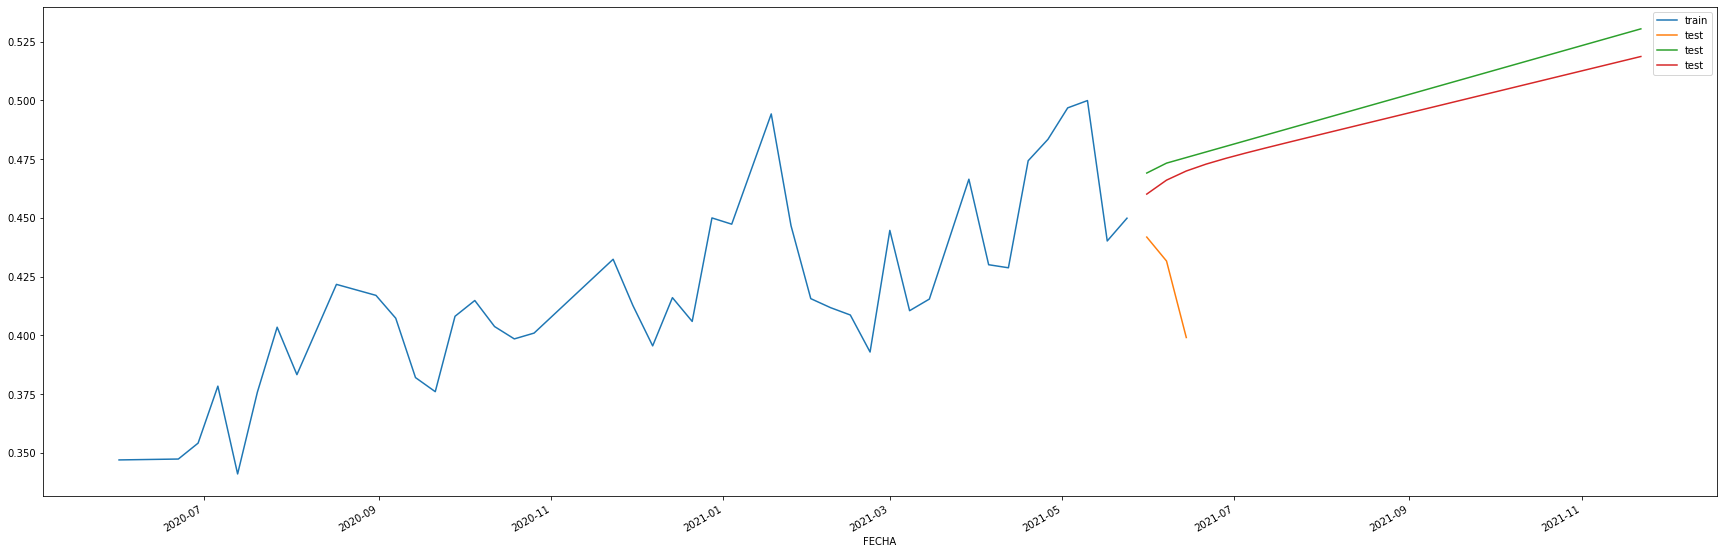

In [73]:
#df_serie_train.sort_values('FECHA',ascending=True).plot(x='FECHA',y='UP',ax=ax, kind='line', label=ind)
fig, ax = plt.subplots(figsize=(30,10))
df_serie_train.reset_index().plot(x='FECHA',y='DW',ax=ax, kind='line', label='train')
df_serie_test.reset_index().plot(x='FECHA',y='DW',ax=ax, kind='line', label='test')
df_auto_fore.reset_index().plot(x='FECHA',y=0,ax=ax, kind='line', label='test')
df_auto_foreC.reset_index().plot(x='FECHA',y=0,ax=ax, kind='line', label='test')

In [81]:
# Función Analisis Series
def analisisSeries(nomNodo):
    df=downstream
    df['FECHA'] =pd.to_datetime(df['FECHA'], dayfirst=True)
    fecha_ini_fore = '2021-05-31'
    fecha_final_fore  = '2021-06-28'
    week_final = pd.to_datetime(fecha_final_fore, dayfirst=True).week
    week_ini = pd.to_datetime(fecha_ini_fore, dayfirst=True).week
    n_periodos_fore = week_final- week_ini +1
    filtro_train = f"FECHA >= '2020-06-01' and FECHA <'{fecha_ini_fore}'"
    filtro_test = f"FECHA >= '{fecha_ini_fore}' and FECHA <='{fecha_final_fore}'"
    nodo = df.loc[df['NODO'] == nomNodo] # Dataframe de Nodo Ejemplo
    nodo = nodo.sort_values("FECHA") 
    df_serie = nodo[["FECHA", "DW"]]
    df_serie.set_index("FECHA", inplace=True)
    df_serie1 = df_serie.asfreq("W-MON")
    df_serie = df_serie.fillna(method = "ffill")
    df_serie_train = df_serie.query(filtro_train)
    df_serie_test = df_serie.query(filtro_test)
    model_auto= auto_arima(df_serie_train,max_p = 4, max_q = 4,trace=False)
    n_periodos_fore=26
    ind = pd.date_range(fecha_ini_fore, periods = n_periodos_fore, freq ='W-MON', name='FECHA')
    df_auto_fore = pd.DataFrame(model_auto.predict(n_periods = len(ind)), index = ind)
    ruta_modelo = f"MODELOS/MODELOS_ARIMA_TRAFICOS/DW_{nomNodo}.pkl"
    model_auto_2 = load(ruta_modelo)
    df_auto_foreC = pd.DataFrame(model_auto_2.predict(n_periods = len(ind)), index = ind)
    fig, ax = plt.subplots(figsize=(30,10))
    df_serie_train.reset_index().plot(x='FECHA',y='DW',ax=ax, kind='line', label='train')
    df_serie_test.reset_index().plot(x='FECHA',y='DW',ax=ax, kind='line', label='test')
    df_auto_fore.reset_index().plot(x='FECHA',y=0,ax=ax, kind='line', label='fore1')
    #df_auto_foreC.reset_index().plot(x='FECHA',y=0,ax=ax, kind='line', label='fore2')


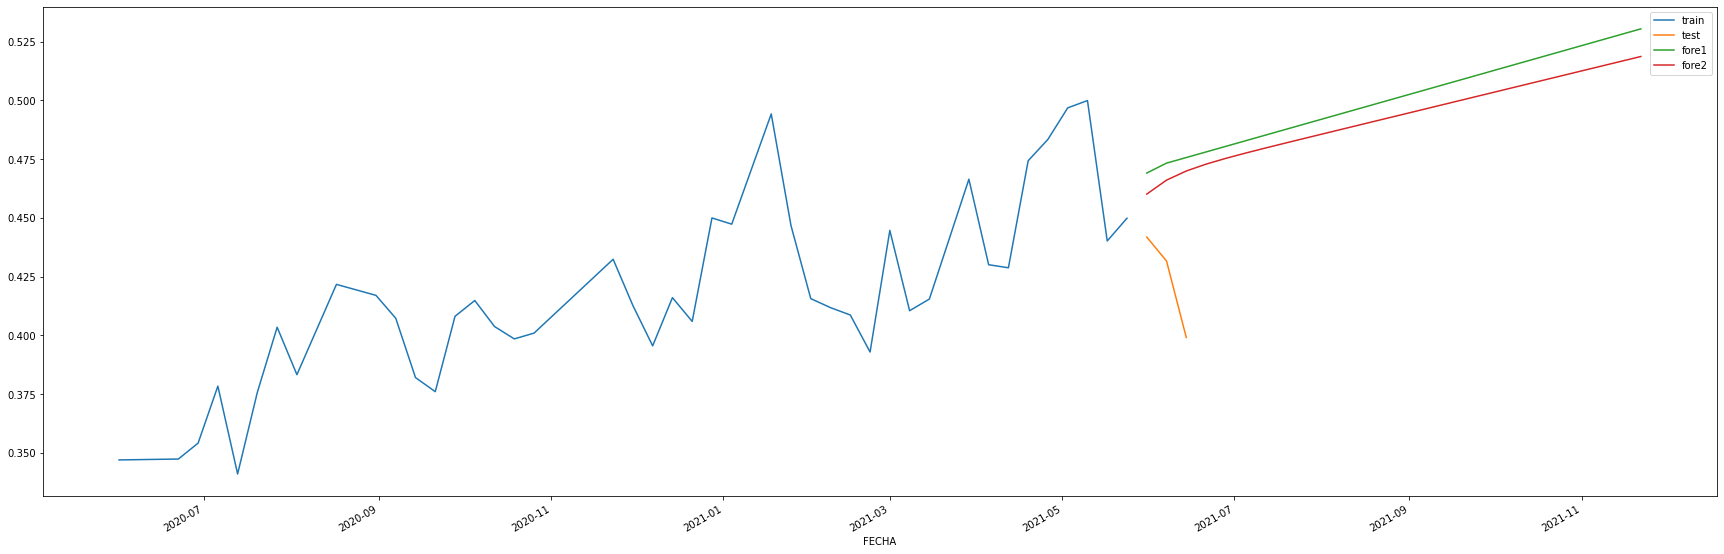

In [75]:
analisisSeries('2NZ')

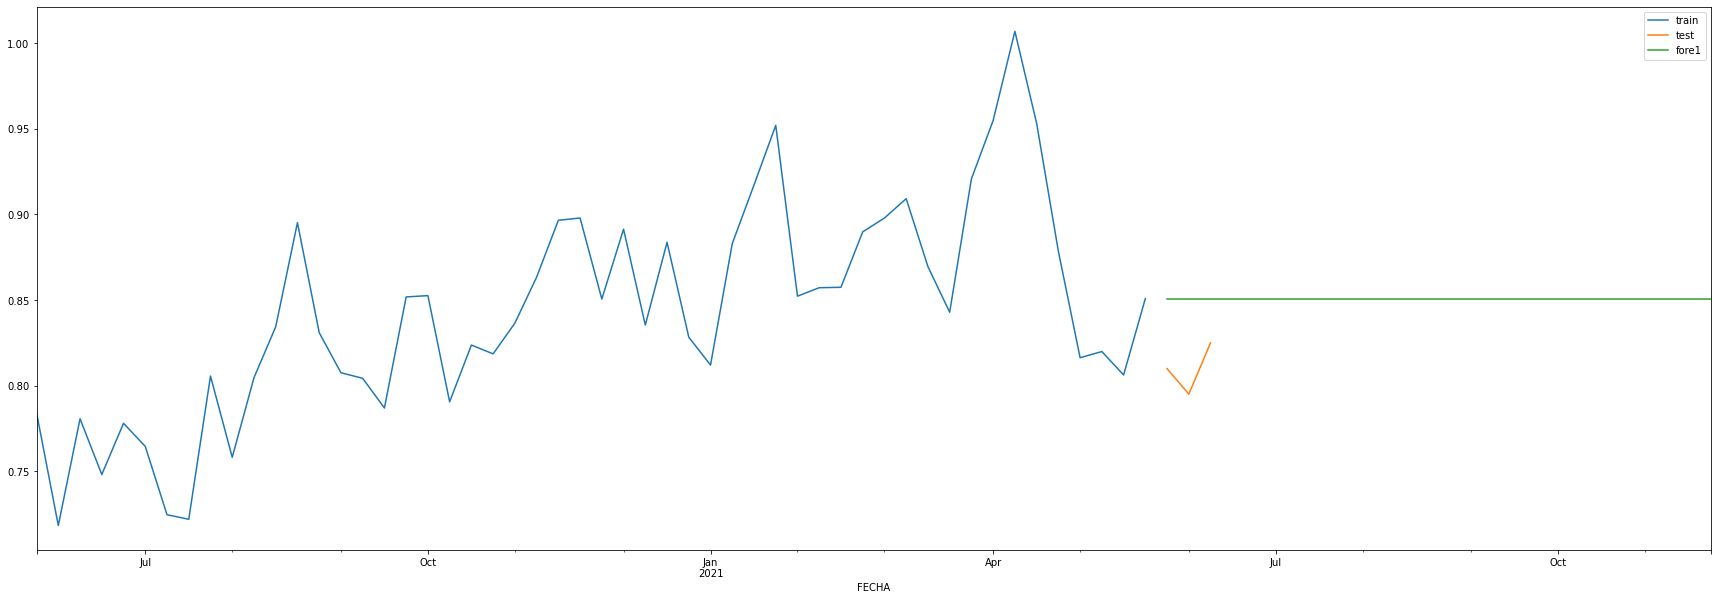

In [82]:
analisisSeries('M4T')

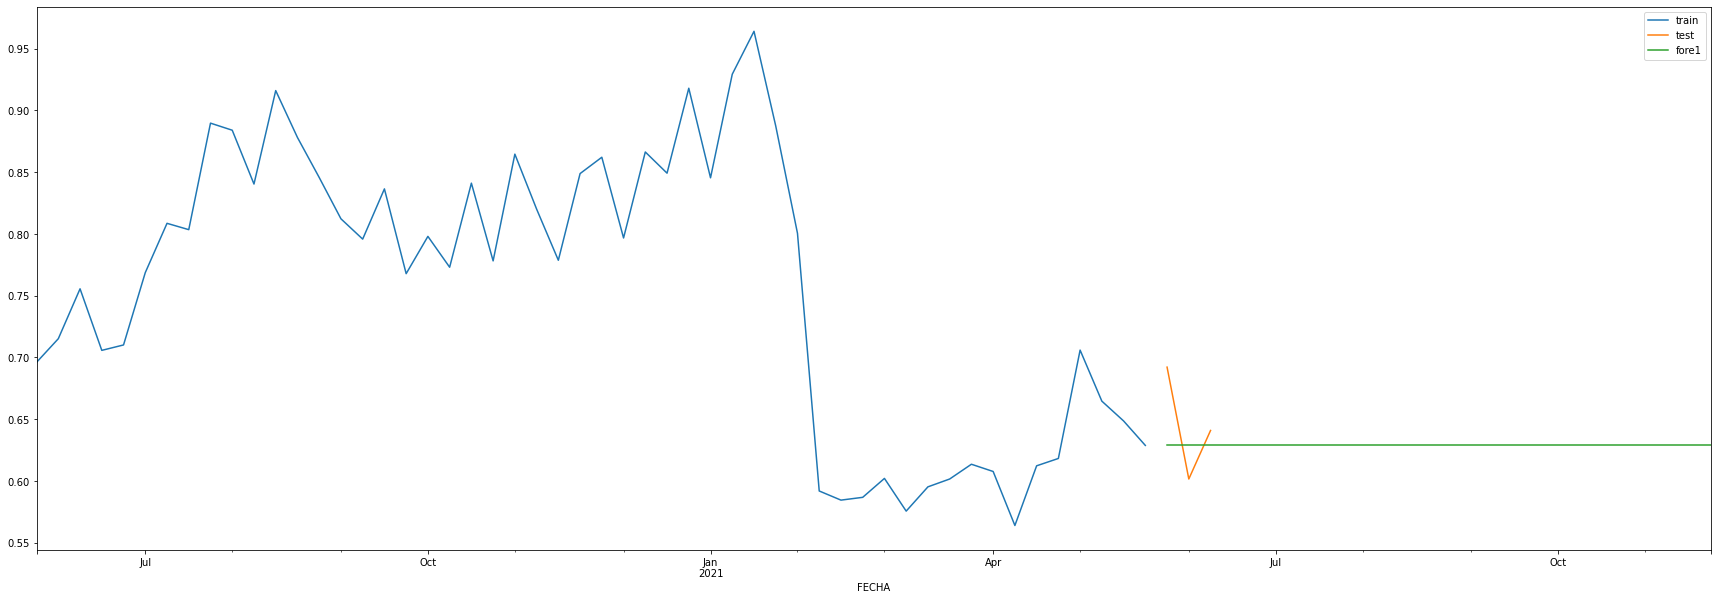

In [83]:
analisisSeries('LVS')

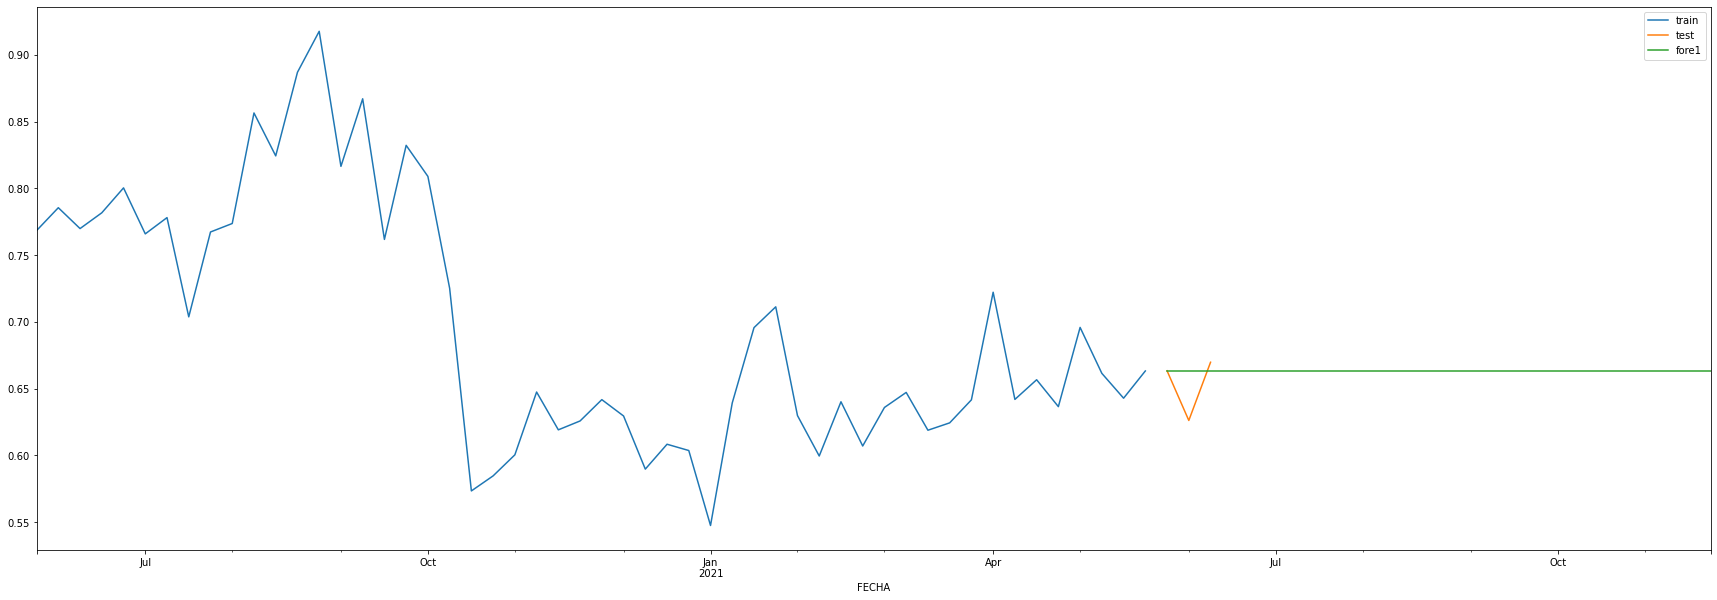

In [84]:
analisisSeries('M2T')

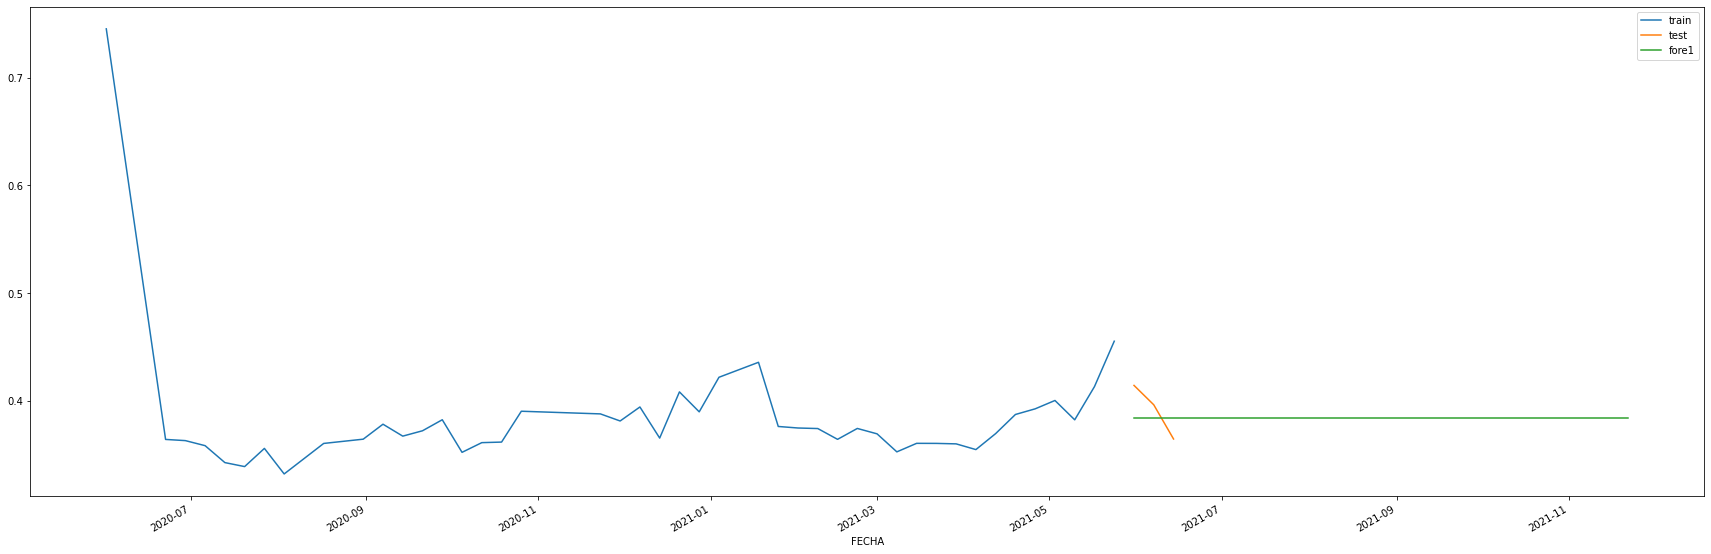

In [85]:
analisisSeries('TZL')

El modelo actual pasa por mucho trabajo para hacer una tendencia

In [86]:
df_auto_fore.columns = ["DW"]
df_final = nodo[["FECHA","DW"]]
df_final.set_index("FECHA", inplace=True)
divi = {'UP':(27*4), 'DW':(38*48)}
forenodo = pd.concat([df_final,df_auto_fore], axis=0)

In [114]:
forenodo.head()

,DW
FECHA,
2020-06-01,0.586174
2020-06-08,0.470370
2020-06-15,0.589201
2020-06-22,0.539743
2020-06-29,0.505061


In [174]:
forenodo["NODO"] = '2NZ'
forenodo[f"OCUPACION_DW"] = forenodo["DW"] 
forenodo["DW"] = forenodo[f"OCUPACION_DW"]*divi["DW"]
#forenodo.to_csv(f"Data_out_modelo/{DW_UP}_{j}.csv", index = True)

In [144]:
forenodo

,DW
FECHA,
2020-06-01,0.586174
2020-06-08,0.470370
2020-06-15,0.589201
2020-06-22,0.539743
2020-06-29,0.505061


In [14]:
data_completa.FECHA.m

'2021-06-14'

#### Prueba LightGBMRegressor
* https://ichi.pro/es/pronostico-de-series-de-tiempo-de-varios-pasos-con-arima-lightgbm-y-prophet-224980043685808

In [92]:
import lightgbm as lgb
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

ModuleNotFoundError: No module named 'sktime'

In [88]:
def create_forecaster():
    
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
    
    return forecaster

def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test))+1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape

In [89]:
param_grid = {"window_length": [5, 10, 15, 20, 25, 30]} # parameter set to be grid searched
forecaster = create_forecaster()
sun_lgb_mae, sun_lgb_mape = grid_serch_forecaster(sun_train, sun_test, forecaster, param_grid)

NameError: name 'lgb' is not defined

###  Fin Exploracion

### Comparar con pronosticos anteriores

In [15]:
downstream.to_csv('Data_Forecast/dwstream.csv', sep=";",decimal=',') # Carga de datos
upstream.to_csv('Data_Forecast/upstream.csv', sep=";",decimal=',') # Carga de datos

In [16]:
limpiar_carpeta_out_modelo()

Verificar: si si


In [17]:
downstream['FECHA'].sort_values().unique()

array(['2020-06-01', '2020-06-08', '2020-06-15', '2020-06-22',
       '2020-06-29', '2020-07-06', '2020-07-13', '2020-07-20',
       '2020-07-27', '2020-08-03', '2020-08-10', '2020-08-17',
       '2020-08-24', '2020-08-31', '2020-09-07', '2020-09-14',
       '2020-09-21', '2020-09-28', '2020-10-05', '2020-10-12',
       '2020-10-19', '2020-10-26', '2020-11-02', '2020-11-09',
       '2020-11-16', '2020-11-23', '2020-11-30', '2020-12-07',
       '2020-12-14', '2020-12-21', '2020-12-28', '2021-01-04',
       '2021-01-11', '2021-01-18', '2021-01-25', '2021-02-01',
       '2021-02-08', '2021-02-15', '2021-02-22', '2021-03-01',
       '2021-03-08', '2021-03-15', '2021-03-22', '2021-03-29',
       '2021-04-05', '2021-04-12', '2021-04-19', '2021-04-26',
       '2021-05-03', '2021-05-10', '2021-05-17', '2021-05-24',
       '2021-05-31', '2021-06-07', '2021-06-14'], dtype=object)

In [19]:
#### fechas de lunes (automatizar fechas)
#### se recomienda dejar tres fechas de validación y predecir dos
fecha_ini_fore = '2021-05-31'
fecha_final_fore  = '2021-06-28'
# Para correr todos colocar -1
n_nodos = 20

In [20]:
run_modelo(downstream, "DW",n_nodos, 
           fecha_ini_fore, fecha_final_fore, load_model=False)

--------------------------------------------------
Tiempo de inicio de la corrida del modelo: 2021-08-12 16:15
--------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.6s finished


--------------------------------------------------
Tiempo de finalización de la corrida del modelo: 2021-08-12 16:15
--------------------------------------------------


In [21]:
run_modelo(upstream, "UP",n_nodos, 
           fecha_ini_fore, fecha_final_fore, load_model=False)

--------------------------------------------------
Tiempo de inicio de la corrida del modelo: 2021-08-12 16:17
--------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.8s finished


--------------------------------------------------
Tiempo de finalización de la corrida del modelo: 2021-08-12 16:17
--------------------------------------------------


In [22]:
df_evaluacion = evaluacion_mape_modelo()

100%|██████████| 37/37 [00:00<00:00, 165.62it/s]

************************************************************
Información de la métrica de evaluación (mape):
************************************************************
EXCELENTE (<=10%)    68.0
BUENO (<=20%)        24.0
REGULAR (<=30%)       8.0
Name: CALIFICACION, dtype: float64
------------------------------------------------------------
Descripción de los puntajes clasificados como malos: 
------------------------------------------------------------
       MAPE
count   0.0
mean    NaN
std     NaN
min     NaN
25%     NaN
50%     NaN
75%     NaN
max     NaN
--------------------------------------------------
Tiempo de ejecución de la evaluación: 0.23440313339233398
--------------------------------------------------
--------------------------------------------------
Evaluación guardada en : Data_Forecast/proyecciones/evaluacion.csv
--------------------------------------------------


In [23]:
### Número de periodos a proyectar se puede automatizar como 2 teniendo en cuenta que las fechas indicadas anteriormente den dos periodos de proyección
periodos_a_proyectar = 2
consolidar_archivo_proyeccion(periodos_a_proyectar)

100%|██████████| 37/37 [00:00<00:00, 537.66it/s]

------------------------------------------------------------
Conteo de nodos: 
 DOWN:
18 
 UP:
19 
------------------------------------------------------------
Conteo de fechas (): 
 Down:
2021-06-28    18
2021-06-21    18
Name: FECHA, dtype: int64 
 UP:
2021-06-28    19
2021-06-21    19
Name: FECHA, dtype: int64
------------------------------------------------------------
Proyecciones guardadas en: Data_Forecast/proyecciones/


In [24]:
# consolidación de archivos para análisis temporal de tendencias 
# de los tráficos, ver notebook claro_nodos_temporal.ipynb
consolidar_archivo_serie_temporal()

100%|██████████| 37/37 [00:00<00:00, 356.72it/s]

----------------------------------------------------------------------------------------------------
Los siguientes archivos no se han agregado a los archivos de series temporales
----------------------------------------------------------------------------------------------------
[]
------------------------------------------------------------
Conteo de nodos: 
 Serie real:
37 
 Proyecciones:
37 
------------------------------------------------------------
Conteo de fechas: 
 Reales:
2021-05-03    37
2020-09-14    37
2020-09-21    37
2020-12-14    37
2021-02-08    37
2021-05-10    37
2021-02-22    37
2020-10-12    37
2021-04-19    37
2020-11-30    37
2021-02-01    37
2021-06-07    37
2021-03-01    37
2021-05-31    37
2020-10-19    37
2020-10-26    37
2021-01-25    37
2020-12-07    37
2021-01-04    37
2021-03-08    37
2021-01-18    37
2021-03-22    37
2021-04-26    37
2020-10-05    37
2021-04-05    37
2021-05-24    37
2021-04-12    37
2020-09-28    37
2021-02-15    37
2021-03-29    37
20

In [25]:
downstream

,CMTS,CABLEMAC,NODO,DW,FECHA
1,BOGO-COT-H-03-CS100G,CATV-MAC 17,TN11,0.616279,2021-02-08
2,VILL-VILL-H-02-CS100G,CATV-MAC 5,VGL,0.672510,2021-06-07
6,BOGO-POLO-H-15-CS100G,CATV-MAC 19,30A013,0.473507,2021-02-01
7,PAST-PASTO-H-01-CS100G,CATV-MAC 37,NVR2D,0.584218,2020-07-13
9,BOGO-FONT-H-02-CS100G,CATV-MAC 13,41D1,0.653036,2020-12-14
...,...,...,...,...,...
1478833,BOGO-VENE-H-06-CS100G,CATV-MAC 10,GLC1,0.392465,2020-10-26
1478837,TUNJ-TUNJA-H-01-CS100G,CATV-MAC 13,SRN,0.387603,2020-11-02
1478838,MEDE-ESUR-H-03-ARRIE6,CABLE-MAC 54,ENG,0.627140,2021-02-22
1478839,CHIA-CHIA-H-03-CS100G,CATV-MAC 11,ILI2D,0.811810,2021-01-25


In [26]:
# fecha inicial corresponde a la penultima semana y final a la última
# semana de la que se tiene registro
divi = {'UP':(27*4), 'DW':(38*48)}
downstream['DW'] = downstream['DW']*divi['DW']
upstream['UP'] = upstream['UP']*divi['UP']
ocup_completo = generar_archivo_unificado(downstream, upstream)
ocup_wide = get_ocup_wide(ocup_completo)

Fechas:  Inicial --> 2021-06-07, Final --> 2021-06-14


In [27]:
# elimiar repetidos, se conserva el de valor máximo en down para 
# la última fecha
ocup_wide.sort_values('DW_FIN', ascending=False, inplace=True)
ocup_wide.drop_duplicates(subset=['NODO'], inplace=True)
sum(ocup_wide.duplicated(subset='NODO'))

0

#### MODIFICAR CADA VEZ QUE SE CAMBIE EL LISTADO DE REQUERIMIENTOS.

In [28]:
path_reque = 'Data_priorizacion\Requerimientos_blindaje\Listado Requerimientosxlsx.xlsx'
blindajes = pd.read_excel(path_reque, dtype = {'ID NODO':str, 'ID ALTERNO':str})

#### No modificar

In [29]:
pred_dw = pd.read_csv('Data_Forecast/proyecciones/dw_proyeccion.csv')
pred_up = pd.read_csv('Data_Forecast/proyecciones/up_proyeccion.csv')
pred_dw.drop_duplicates(subset=['NODO','FECHA'],inplace=True)
pred_up.drop_duplicates(subset=['NODO','FECHA'],inplace=True)
ocup_blindaje = ocup_wide.merge(blindajes, left_on = 'NODO', right_on ='ID NODO', how = 'left')
ocup_blindaje.loc[ocup_blindaje['NOMBRE DEL PLAN'].isna(), 'NOMBRE DEL PLAN'] = 'Resto del Pais'

#### MODIFICAR CADA VEZ QUE SE CORRA EL ANÁLISIS

In [30]:
# automatizar fechas de las semanas posteriores en las entradas de la siguiente función
ocup_proyeccion = get_ocup_proyeccion(pred_dw, pred_up, ocup_blindaje,'2021-06-21','2021-06-28')   

In [31]:
df_evaluacion = pd.read_csv('Data_Forecast/proyecciones/evaluacion.csv')
serie_real = pd.read_csv('Data_Forecast/series_temporales/series_reales.csv')
tabla_frec_rojos = get_frecuencia_rojos(serie_real)
priorizacion = get_priorizacion(ocup_proyeccion, 
                                df_evaluacion, tabla_frec_rojos)

Los csv de priorización fueron guardados en la carpeta Data_priorizacion.


***Para generar el archivo con información geográfica ir al cuadernillo análisis_geo***